In [150]:
#importing necessary libraries
import pandas as pd
import glob
import os
import warnings
import time
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
# importing custom scripts for different functions
sys.path.append('scripts')  # add scripts to path




# Ignore warnings
warnings.filterwarnings("ignore")

In [151]:
data = pd.read_csv("combined.csv")
data.head()

,Commodity,Classification,Grade,Sex,Market,Wholesale,Retail,Supply Volume,County,Date
0,Banana (Ripening),-,-,-,Mukuyu Market,-,50.00/Kg,NaN,Muranga,2026-02-11
1,Banana (Ripening),-,-,-,Mulot,70.00/Kg,100.00/Kg,1500.0,Bomet,2026-02-11
2,Banana (Ripening),-,-,-,Kitale Municipality Market,80.00/Kg,100.00/Kg,6000.0,Trans-Nzoia,2026-02-11
3,Banana (Ripening),-,-,-,Kerugoya,20.00/Kg,40.00/Kg,300.0,Kirinyaga,2026-02-10
4,Banana (Ripening),-,-,-,Bondeni,80.00/Kg,100.00/Kg,5000.0,Trans-Nzoia,2026-02-10


In [152]:
data.isnull().sum()

Commodity             0
Classification        0
Grade                 0
Sex                   0
Market                0
Wholesale             0
Retail                0
Supply Volume     17775
County               19
Date                  0
dtype: int64

In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57010 entries, 0 to 57009
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       57010 non-null  object 
 1   Classification  57010 non-null  object 
 2   Grade           57010 non-null  object 
 3   Sex             57010 non-null  object 
 4   Market          57010 non-null  object 
 5   Wholesale       57010 non-null  object 
 6   Retail          57010 non-null  object 
 7   Supply Volume   39235 non-null  float64
 8   County          56991 non-null  object 
 9   Date            57010 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.3+ MB


In [154]:
data.duplicated().sum()

np.int64(4259)

In [155]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52751 entries, 0 to 52750
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       52751 non-null  object 
 1   Classification  52751 non-null  object 
 2   Grade           52751 non-null  object 
 3   Sex             52751 non-null  object 
 4   Market          52751 non-null  object 
 5   Wholesale       52751 non-null  object 
 6   Retail          52751 non-null  object 
 7   Supply Volume   36539 non-null  float64
 8   County          52743 non-null  object 
 9   Date            52751 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.0+ MB


In [157]:
data['County'] = data.groupby('Market')['County'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

In [158]:
# Filling NaNs using the median volume for each specific commodity
data['Supply Volume'] = data.groupby(['Commodity', 'Market'])['Supply Volume'].transform(lambda x: x.fillna(x.median()))
#data['Supply Volume'] = data['Supply Volume'].fillna(0)

In [159]:
data.isnull().sum()

Commodity            0
Classification       0
Grade                0
Sex                  0
Market               0
Wholesale            0
Retail               0
Supply Volume     9251
County               0
Date                 0
dtype: int64

In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52751 entries, 0 to 52750
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Commodity       52751 non-null  object 
 1   Classification  52751 non-null  object 
 2   Grade           52751 non-null  object 
 3   Sex             52751 non-null  object 
 4   Market          52751 non-null  object 
 5   Wholesale       52751 non-null  object 
 6   Retail          52751 non-null  object 
 7   Supply Volume   43500 non-null  float64
 8   County          52751 non-null  object 
 9   Date            52751 non-null  object 
dtypes: float64(1), object(9)
memory usage: 4.0+ MB


In [161]:
data['Supply Volume'] = data.groupby('Commodity')['Supply Volume'].transform(lambda x: x.fillna(x.median()))

In [162]:
data= data.drop(columns=["Classification", "Grade", "Sex"])

In [163]:
data.head()

,Commodity,Market,Wholesale,Retail,Supply Volume,County,Date
0,Banana (Ripening),Mukuyu Market,-,50.00/Kg,1500.0,Muranga,2026-02-11
1,Banana (Ripening),Mulot,70.00/Kg,100.00/Kg,1500.0,Bomet,2026-02-11
2,Banana (Ripening),Kitale Municipality Market,80.00/Kg,100.00/Kg,6000.0,Trans-Nzoia,2026-02-11
3,Banana (Ripening),Kerugoya,20.00/Kg,40.00/Kg,300.0,Kirinyaga,2026-02-10
4,Banana (Ripening),Bondeni,80.00/Kg,100.00/Kg,5000.0,Trans-Nzoia,2026-02-10


In [164]:
data.isnull().sum()

Commodity        0
Market           0
Wholesale        0
Retail           0
Supply Volume    0
County           0
Date             0
dtype: int64

In [165]:
def clean_price(series):
	clean_series = pd.to_numeric(series.astype(str).str.replace('[^0-9.]', '', regex=True), errors='coerce')
	return clean_series

data["Wholesale"] = clean_price(data["Wholesale"])
data["Retail"] = clean_price(data["Retail"])

In [166]:
data.isnull().sum()

Commodity            0
Market               0
Wholesale        11061
Retail            2194
Supply Volume        0
County               0
Date                 0
dtype: int64

In [167]:
data["Wholesale"] = data["Wholesale"].fillna(0)
data["Retail"] = data["Retail"].fillna(0)

In [168]:
data.isnull().sum()

Commodity        0
Market           0
Wholesale        0
Retail           0
Supply Volume    0
County           0
Date             0
dtype: int64

In [169]:
# Calculate absolute price difference
data['Price_Margin'] = data['Retail'] - data['Wholesale']
data = data[data['Wholesale'] > 0].copy()
# Calculate percentage margin, handling division by zero
data['Margin_Percentage'] = (data['Price_Margin'] / data['Wholesale']) * 100

In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41690 entries, 1 to 52750
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Commodity          41690 non-null  object 
 1   Market             41690 non-null  object 
 2   Wholesale          41690 non-null  float64
 3   Retail             41690 non-null  float64
 4   Supply Volume      41690 non-null  float64
 5   County             41690 non-null  object 
 6   Date               41690 non-null  object 
 7   Price_Margin       41690 non-null  float64
 8   Margin_Percentage  41690 non-null  float64
dtypes: float64(5), object(4)
memory usage: 3.2+ MB


#### Which are Top 10 Commodities by Average Margin Percentage?

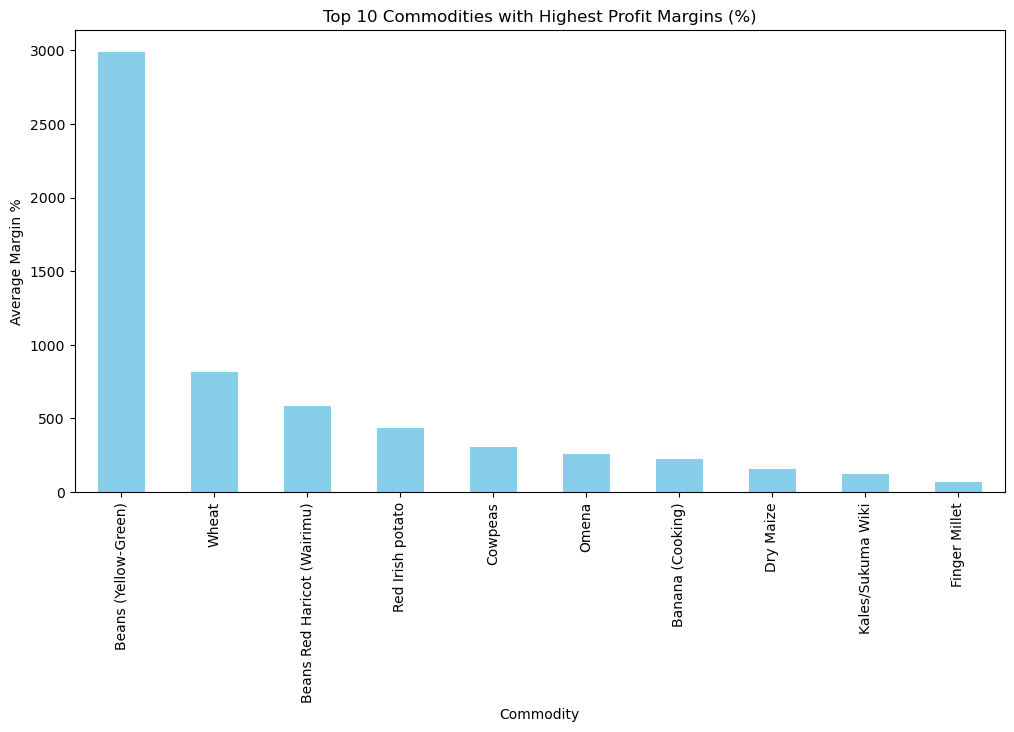

In [171]:
plt.figure(figsize=(12, 6))
data.groupby('Commodity')['Margin_Percentage'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Commodities with Highest Profit Margins (%)')
plt.ylabel('Average Margin %')
plt.show()

**Yellow-Green beans makes the highest profit margin**

#### Which are Top 10 Counties by Total Supply Volume?

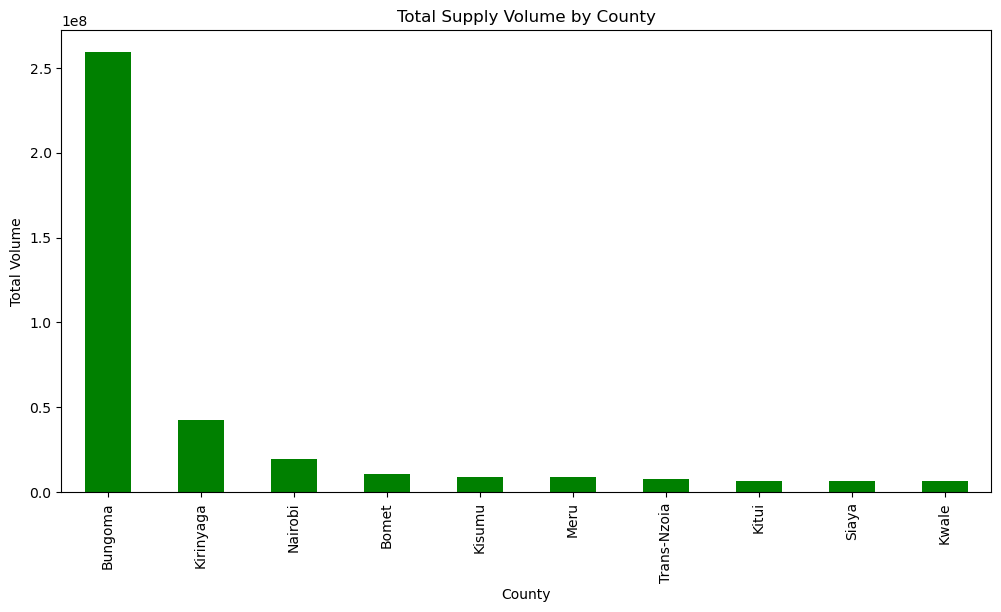

In [172]:
plt.figure(figsize=(12, 6))
data.groupby('County')['Supply Volume'].sum().sort_values(ascending=False).head(10).plot(kind='bar', color='green')
plt.title('Total Supply Volume by County')
plt.ylabel('Total Volume')
plt.show()

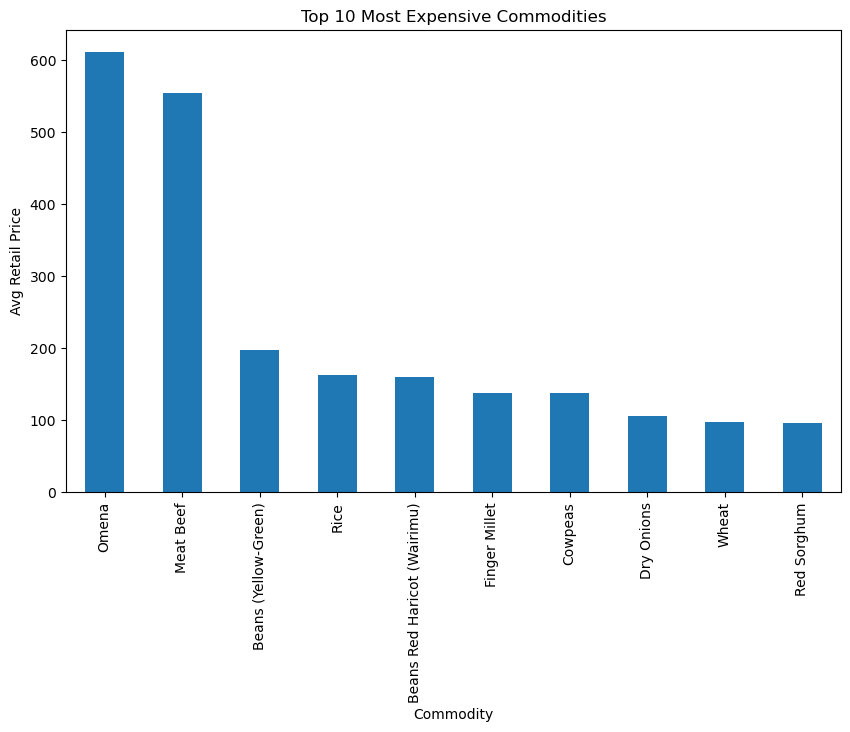

In [173]:
plt.figure(figsize=(10,6))
data.groupby('Commodity')['Retail'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel("Avg Retail Price")
plt.title("Top 10 Most Expensive Commodities")
plt.show()

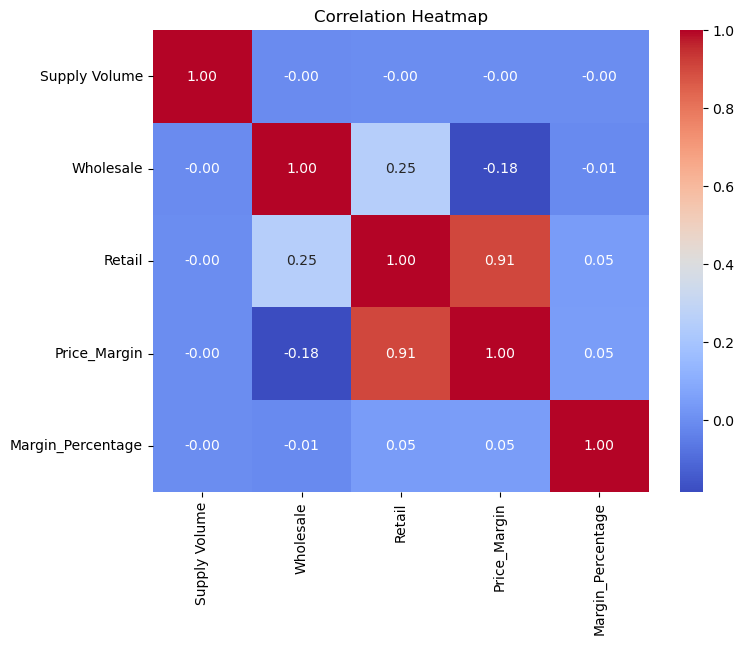

In [174]:
plt.figure(figsize=(8, 6))
correlation = data[['Supply Volume', 'Wholesale', 'Retail', 'Price_Margin', 'Margin_Percentage']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

**Supply volume have no correlation with the prices both wholesale and retail where as The price margin has a strong positive correlation of 91% with Retail prices.**

In [175]:
# Sorting data by Date and Commodity
data = data.sort_values(['Commodity', 'Date'])

# Using linear interpolation to fill gaps in price trends
data['Retail'] = data.groupby('Commodity')['Retail'].transform(lambda x: x.interpolate(method='linear'))
data['Wholesale'] = data.groupby('Commodity')['Wholesale'].transform(lambda x: x.interpolate(method='linear'))

In [176]:
# Calculate Coefficient of Variation - a measure of volatility
volatility = data.groupby('Commodity')['Retail'].std() / data.groupby('Commodity')['Retail'].mean()
print("Top 5 Most Volatile Commodities (Hardest to predict):")
print(volatility.sort_values(ascending=False).head())

Top 5 Most Volatile Commodities (Hardest to predict):
Commodity
Banana (Cooking)               3.915273
Dry Maize                      3.300950
Beans Red Haricot (Wairimu)    3.284186
Beans (Yellow-Green)           3.184903
Finger Millet                  2.875688
Name: Retail, dtype: float64


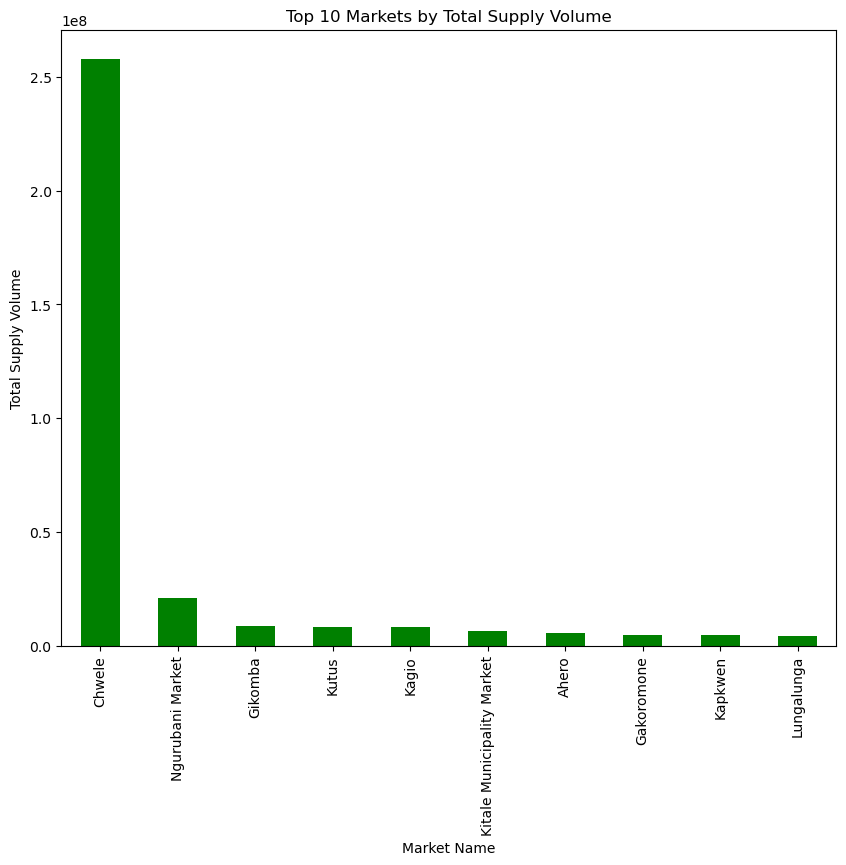

In [177]:
plt.figure(figsize=(10,8))
data.groupby('Market')['Supply Volume'].sum().sort_values(ascending=False).head(10).plot(kind='bar', color='green')
plt.xlabel("Market Name")
plt.ylabel("Total Supply Volume")
plt.title('Top 10 Markets by Total Supply Volume')
plt.show()

In [178]:
# Creating a list of markets for major cities
Nairobi_data = data[data['County'].str.contains('Nairobi', case=False, na=False)]


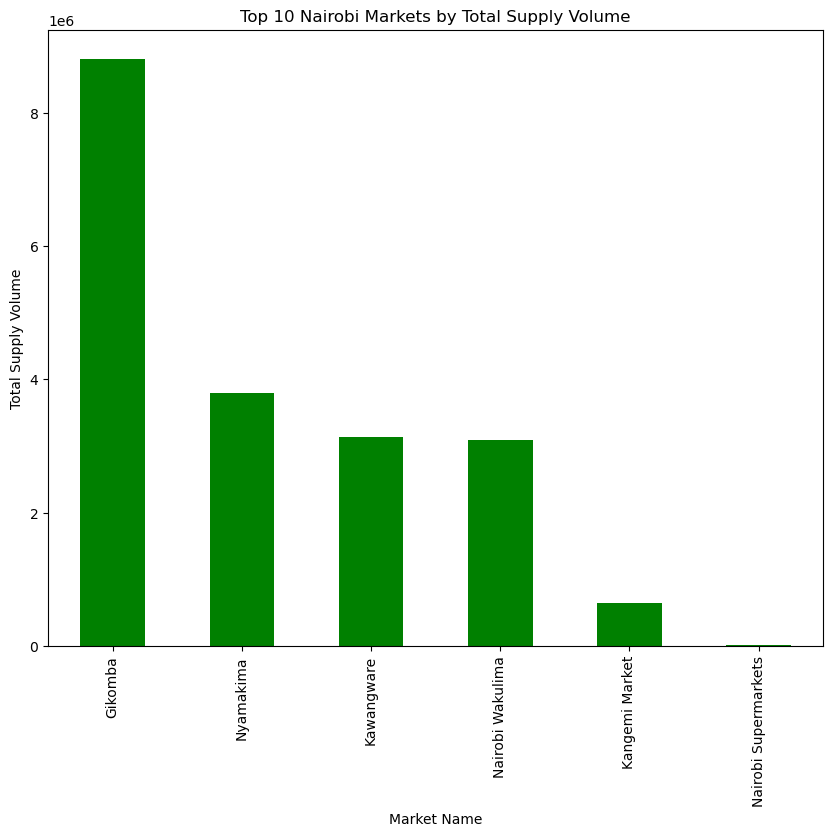

In [179]:
plt.figure(figsize=(10,8))
Nairobi_data.groupby('Market')['Supply Volume'].sum().sort_values(ascending=False).head(10).plot(kind='bar', color='green')
plt.xlabel("Market Name")
plt.ylabel("Total Supply Volume")
plt.title('Top 10 Nairobi Markets by Total Supply Volume')
plt.show()

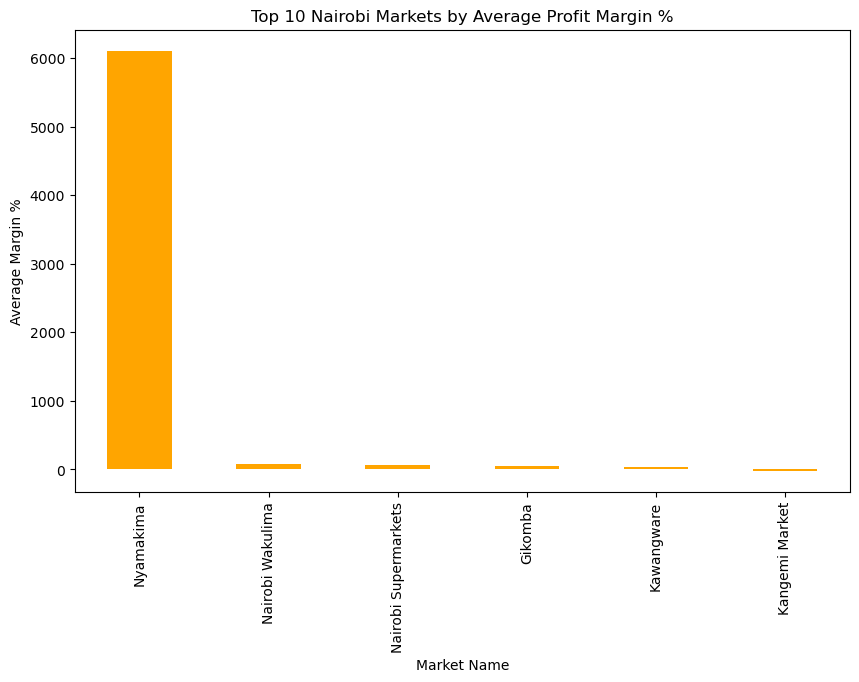

In [180]:
plt.figure(figsize=(10,6))
Nairobi_data.groupby('Market')['Margin_Percentage'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='orange')
plt.xlabel("Market Name")
plt.ylabel("Average Margin %")
plt.title('Top 10 Nairobi Markets by Average Profit Margin %')
plt.show()

Modelling

In [181]:
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date")

In [182]:
commodity_name = 'Rice'
df_commodity = data[data['Commodity'] == commodity_name].copy()

In [183]:
ts_data = df_commodity.groupby('Date').agg({'Retail':'mean', 'Wholesale':'mean', 'Supply Volume':'mean'}).resample('D').mean().ffill().bfill()

In [184]:
ts_data = ts_data.dropna()

In [185]:
print(ts_data.head())

                Retail   Wholesale  Supply Volume
Date                                             
2024-04-18  115.714286  152.857143    2578.571429
2024-04-19  127.500000  150.541250    8962.500000
2024-04-20  160.000000  131.000000    4000.000000
2024-04-21  160.000000  131.000000    4000.000000
2024-04-22  137.500000  131.125000    4243.750000


In [186]:
def check_stationarity(timeseries, title):
    """
				Performing ADF and KPSS tests for stationarity
				"""
    print(f'\n{title}')
    print('='*50)
    adf_result = adfuller(timeseries.dropna(), autolag='AIC')
    print(f'ADF Statistic:{adf_result[0]:.5f}')
    print(f'p-value: {adf_result[1]:5f}')
    print(f'Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value:3f}')
    if adf_result[1] <= 0.05:
        print("Result: Stationary (reject null hypothesis)")
    else:
        print("Result: Non-stationary (fail to reject null hypothesis)")

In [187]:
# Testing original price
check_stationarity(ts_data['Retail'], 'Original Retail Price')


Original Retail Price
ADF Statistic:-3.07532
p-value: 0.028434
Critical Values:
	1%: -3.440545
	5%: -2.866038
	10%: -2.569166
Result: Stationary (reject null hypothesis)


In [188]:
# Test first difference
ts_diff = ts_data['Retail'].diff().dropna()
check_stationarity(ts_diff, 'First Difference of Retail Price')


First Difference of Retail Price
ADF Statistic:-10.17947
p-value: 0.000000
Critical Values:
	1%: -3.440545
	5%: -2.866038
	10%: -2.569166
Result: Stationary (reject null hypothesis)


In [189]:
train_size = int(len(ts_data) * 0.8)
train_data = ts_data['Retail'][:train_size]
test_data = ts_data['Retail'][train_size:]
print(f"Train set: {len(train_data)}, Test set: {len(test_data)}")

Train set: 532, Test set: 133


In [190]:
model_sarima = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
results_sarima = model_sarima.fit(disp=False)
print(results_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Retail   No. Observations:                  532
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2464.908
Date:                            Thu, 19 Feb 2026   AIC                           4939.815
Time:                                    14:35:30   BIC                           4960.938
Sample:                                04-18-2024   HQIC                          4948.100
                                     - 10-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1266      0.028      4.518      0.000       0.072       0.182
ma.L1         -0.8898      0.018   

In [191]:
test_predictions = results_sarima.get_forecast(steps=len(test_data))
test_pred_df = test_predictions.conf_int()
test_pred_df['predictions'] = test_predictions.predicted_mean

In [192]:
mae_sarima = mean_absolute_error(test_data, test_pred_df['predictions'])
rmse_sarima = np.sqrt(mean_squared_error(test_data, test_pred_df['predictions']))
mape_sarima = mean_absolute_percentage_error(test_data, test_pred_df['predictions'])
test_pred_df['predictions']

2025-10-02    178.437162
2025-10-03    174.080089
2025-10-04    178.676230
2025-10-05    174.393279
2025-10-06    176.145303
                 ...    
2026-02-07    193.491651
2026-02-08    185.495634
2026-02-09    190.385243
2026-02-10    193.229698
2026-02-11    188.657295
Freq: D, Name: predictions, Length: 133, dtype: float64

In [193]:
print(f"\nTest Set Performance:")
print(f"MAE: {mae_sarima:.4f}")
print(f"RMSE: {rmse_sarima:.4f}")
print(f"MAPE: {mape_sarima:.4f}")


Test Set Performance:
MAE: 17.6129
RMSE: 21.3024
MAPE: 0.1110


XGBOOST MODELLING

In [194]:
def create_features(df):
    df = df.copy()
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month
    df['day_of_week'] = df.index.dayofweek
    df['week_of_year'] = df.index.isocalendar().week
    for lag in [1, 7, 14, 30]:
            df[f'lag_{lag}'] = df['Retail'].shift(lag)
    for window in [7, 14, 30]:
        df[f"rolling_mean_{window}"] = df['Retail'].rolling(window).mean()
        df[f"rollinf_std_{window}"] = df['Retail'].rolling(window).std()
        return df.dropna()
    

In [195]:
df_features = create_features(ts_data.copy())
feature_cols = [col for col in df_features.columns if col!= 'Retail']

In [196]:
X = df_features[feature_cols]
y = df_features['Retail']

In [197]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, shuffle = False)

In [198]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)

In [199]:
xgb_model.fit(X_train_xgb, y_train_xgb)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [200]:
xgb_predictions = xgb_model.predict(X_test_xgb)


In [201]:
xgb_mae = mean_absolute_error(y_test_xgb, xgb_predictions)
print(f"MAE: {xgb_mae:.4f}")
xgb_mape = mean_absolute_percentage_error(y_test_xgb, xgb_predictions)
print(f"MAPE: {xgb_mape:.4f}")
xgb_rmse = np.sqrt(mean_squared_error(y_test_xgb, xgb_predictions))
print(f"XGBOOST RMSE:	{xgb_rmse:.4f}")


MAE: 7.5039
MAPE: 0.0463
XGBOOST RMSE:	9.9854


LSTM

In [202]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(ts_data[['Retail']])


In [203]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [204]:
seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

In [205]:
train_size = int(len(X) * 0.8)
X_train_lstm, X_test_lstm = X[:train_size], X[train_size:]
y_train_lstm, y_test_lstm = y[:train_size], y[train_size:]

In [206]:
print(f"X_train shape: {X_train_lstm.shape}, y_train shape: {y_train_lstm.shape}")
print(f"X_test shape: {X_test_lstm.shape}, y_test shape: {y_test_lstm.shape}")


X_train shape: (484, 60, 1), y_train shape: (484, 1)
X_test shape: (121, 60, 1), y_test shape: (121, 1)


In [207]:
model_lstm = Sequential([LSTM(50, return_sequences=True, input_shape=(seq_length, 1)), Dropout(0.2), LSTM(50, return_sequences=True), Dropout(0.2), LSTM(25), Dropout(0.2), Dense(1)])

In [208]:
model_lstm.compile(optimizer='adam', loss='mse', metrics = ['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [209]:
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step - loss: 0.0504 - mae: 0.1781 - val_loss: 0.0016 - val_mae: 0.0214
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 0.0077 - mae: 0.0593 - val_loss: 0.0017 - val_mae: 0.0218
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.0069 - mae: 0.0526 - val_loss: 0.0020 - val_mae: 0.0262
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - loss: 0.0067 - mae: 0.0520 - val_loss: 0.0017 - val_mae: 0.0232
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 568ms/step - loss: 0.0059 - mae: 0.0489 - val_loss: 0.0018 - val_mae: 0.0228
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 723ms/step - loss: 0.0058 - mae: 0.0471 - val_loss: 0.0017 - val_mae: 0.0220
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - loss: 0.0054 - mae: 0.0468 - val_loss: 0.0016 - val_mae: 0.0203
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step - loss: 0.0059 - mae: 0.0467 - val_loss: 0.0020 - val_mae: 0.0310
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step -

In [210]:
lstm_preds= model_lstm.predict(X_test_lstm)
lstm_preds = scaler.inverse_transform(lstm_preds)
y_test_actual = scaler.inverse_transform(y_test_lstm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step


In [211]:
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, lstm_preds))
print(f"LSTM RMSE: {rmse_lstm:.2f}")
lstm_mae = mean_absolute_error(y_test_actual, lstm_preds)
print(f"MAE: {lstm_mae:.2f}")
lstm_mape = mean_absolute_percentage_error(y_test_actual, lstm_preds)
print(f"MAPE: {lstm_mape:.2f}")

LSTM RMSE: 12.80
MAE: 9.65
MAPE: 0.06


In [212]:
forecast_steps = 30
forecast = results_sarima.get_forecast(steps=forecast_steps)
forecast_df = forecast.conf_int()
forecast_df['forecast'] = forecast.predicted_mean


In [213]:
comparison = pd.DataFrame({
    'Model': ['SARIMA', 'LSTM', 'XGBoost'],
    'MAE': [mae_sarima, lstm_mae, xgb_mae],
    'RMSE': [rmse_lstm, rmse_lstm, xgb_rmse],
    'MAPE': [lstm_mape, lstm_mae, xgb_mape]})

In [214]:
#fig, axes = plt.subplots(1, 3, figsize=(15, 4))
#for idx, metric in enumerate(['MAE', 'RMSE', 'MAPE']):
    #axes[idx].bar(comparison['Model'], comparison[metric])
    #axes[idx].set_title(f'{metric} Comparison')
    #axes[idx].set_ylabel(metric)
    #axes[idx].grid(True, alpha=0.3)
#plt.tight_layout()
#plt.show()